# Natural Language Processing with Disaster Tweets

Predict which Tweets are about real disasters and which ones are not with [Data from Kaggle](https://www.kaggle.com/c/nlp-getting-started/overview).

This is binary classification task and I plan to use the Long Short-Term Memory (LSTM) Recurrent Neural Network (RNN) for this project after cleaning up the data processing.

In [ ]:
# !pip install pandas seaborn matplotlib wordcloud nltk tensorflow scikit-learn

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from collections import Counter
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [63]:
# !kaggle competitions download -c nlp-getting-started
# !unzip nlp-getting-started.zip -d data

In [64]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jonathan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploratory Data Analysis

I did some general data exploring. I'm not going to use the keyword or location and instead focus on the text since a lot of data is missing in those columns.

There are 7613 entries in total and over 1,000 more non-disasters related tweets than disaster related ones.

To clean the data I lower-cased all words and removed stop-words, urls, mentions, and punctuation and special characters.

In [82]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [83]:
print(train_df.shape)
train_df.info()
train_df.isnull().sum()
train_df['target'].value_counts()

(7613, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


target
0    4342
1    3271
Name: count, dtype: int64

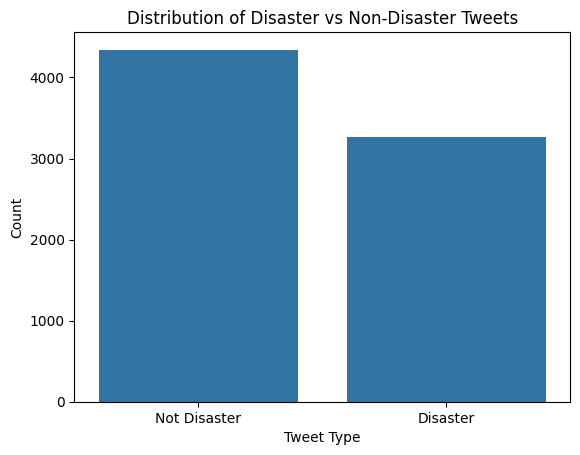

In [84]:
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Disaster vs Non-Disaster Tweets')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'])
plt.xlabel('Tweet Type')
plt.ylabel('Count')
plt.show()

In [85]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

train_df['clean_text'] = train_df['text'].apply(clean_text)

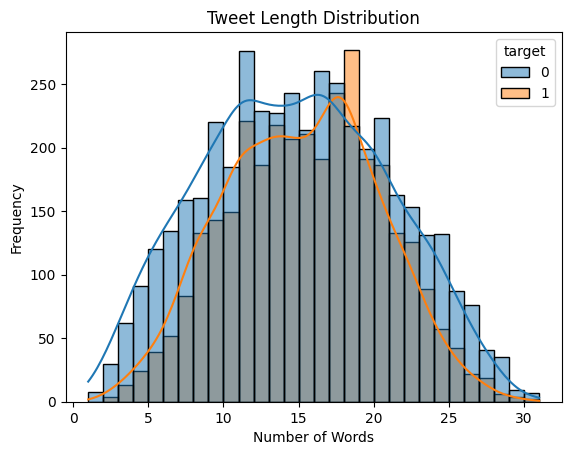

In [86]:
train_df['text_len'] = train_df['text'].apply(lambda x: len(x.split()))

sns.histplot(data=train_df, x='text_len', hue='target', bins=30, kde=True)
plt.title('Tweet Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

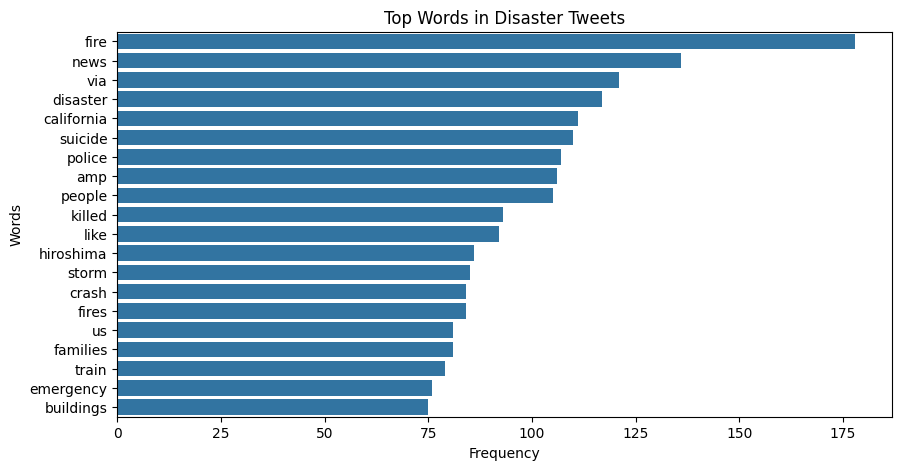

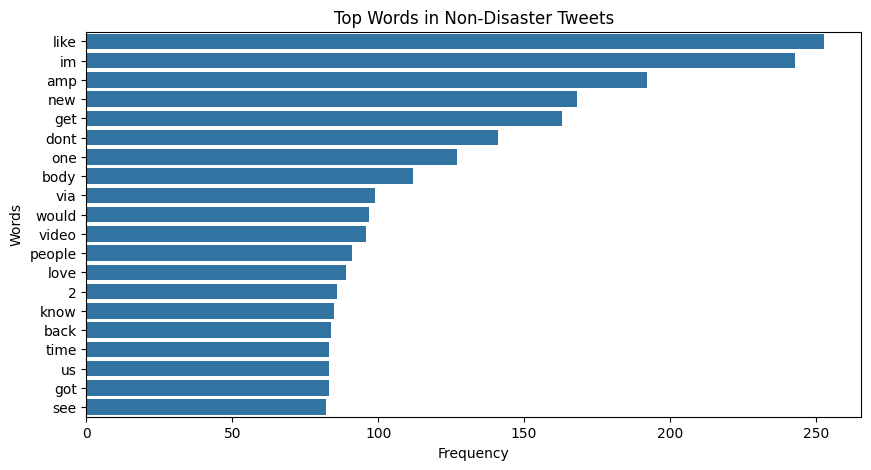

In [ ]:
def plot_common_words(target_value, title):
    texts = train_df[train_df['target'] == target_value]['clean_text']
    all_words = ' '.join(texts).split()
    common_words = Counter(all_words).most_common(20)

    words, counts = zip(*common_words)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.show()

plot_common_words(1, "Top Words in Disaster Tweets")
plot_common_words(0, "Top Words in Non-Disaster Tweets")

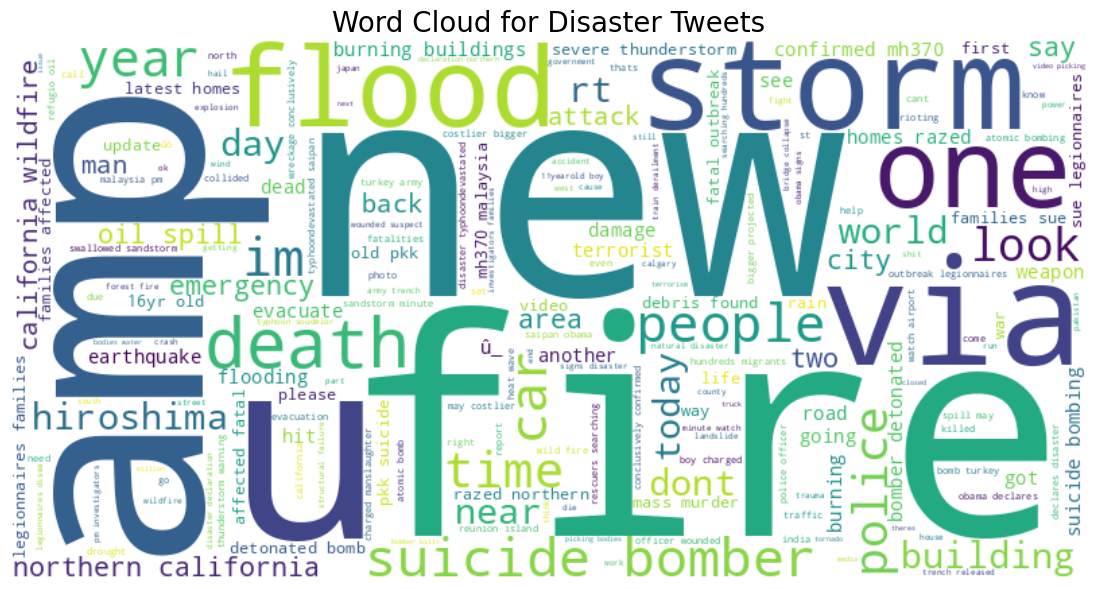

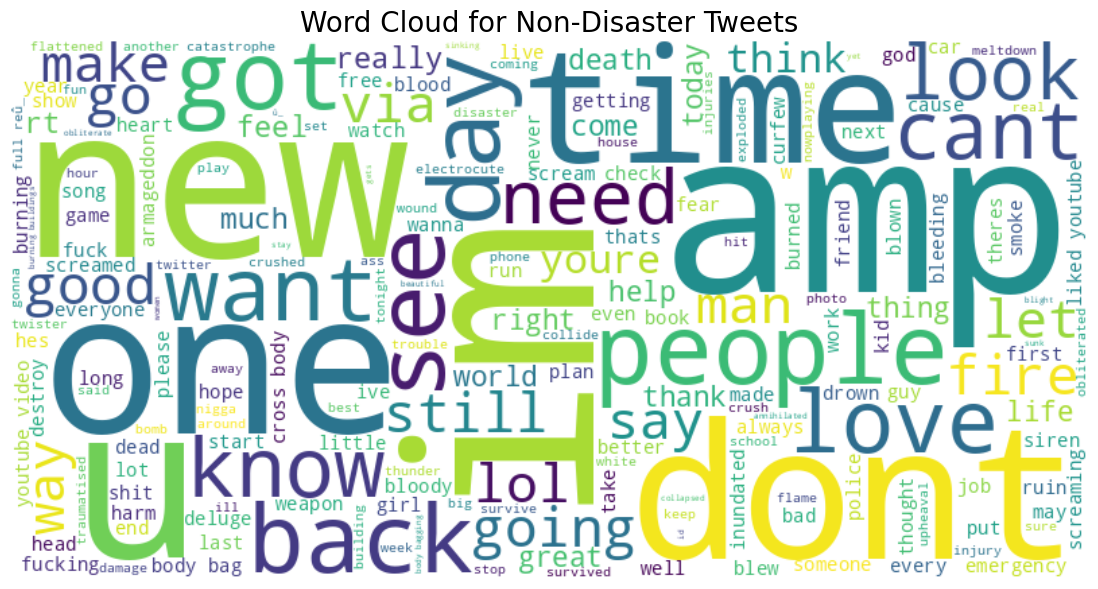

In [88]:
def show_wordcloud(target_value, title):
    text = ' '.join(train_df[train_df['target'] == target_value]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

show_wordcloud(1, 'Word Cloud for Disaster Tweets')
show_wordcloud(0, 'Word Cloud for Non-Disaster Tweets')

# Model Building and Training

I started with a tokenizer on using the top 10,000 words. Then build a sequential model in Keras.

1. Embedding - Converts each word index in the sequence into a 64-dimensional vector
2. LSTM - Long Short-Term Memory layer with 64 units
3. Dropout - Randomly drops 50% of LSTM outputs during training to prevent overfitting.
4. Dense - output 1 neuron with a sigmoid activation for a probability between 0 and 1 for binary classification.

In [72]:
MAX_VOCAB = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['clean_text'])

X_seq = tokenizer.texts_to_sequences(train_df['clean_text'])
X_pad = pad_sequences(X_seq, maxlen=MAX_LEN)

y = train_df['target']

In [73]:
X_train, X_val, y_train, y_val = train_test_split(X_pad, y, test_size=0.2, random_state=42)

model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=64, input_length=MAX_LEN),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
model.summary()

/Users/jonathan/.pyenv/versions/3.12.7/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [74]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    verbose=2
)

Epoch 1/5
191/191 - 3s - 15ms/step - auc: 0.7554 - loss: 0.5718 - val_auc: 0.8474 - val_loss: 0.4540
Epoch 2/5
191/191 - 2s - 12ms/step - auc: 0.9253 - loss: 0.3350 - val_auc: 0.8452 - val_loss: 0.4808
Epoch 3/5
191/191 - 2s - 12ms/step - auc: 0.9653 - loss: 0.2285 - val_auc: 0.8342 - val_loss: 0.5900
Epoch 4/5
191/191 - 2s - 12ms/step - auc: 0.9814 - loss: 0.1639 - val_auc: 0.8219 - val_loss: 0.6628
Epoch 5/5
191/191 - 2s - 12ms/step - auc: 0.9882 - loss: 0.1265 - val_auc: 0.8214 - val_loss: 0.7323


# Results

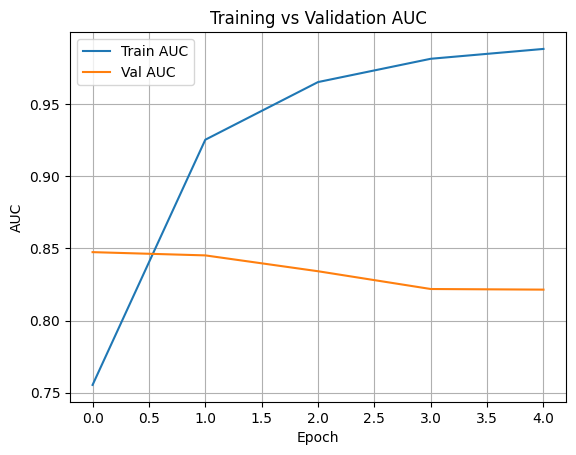

In [75]:
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Training vs Validation AUC')
plt.grid(True)
plt.show()

In [76]:
preds = model.predict(X_val)
labels = (preds > 0.5).astype(int).reshape(-1)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


              precision    recall  f1-score   support

           0       0.78      0.77      0.78       874
           1       0.70      0.71      0.70       649

    accuracy                           0.74      1523
   macro avg       0.74      0.74      0.74      1523
weighted avg       0.74      0.74      0.74      1523



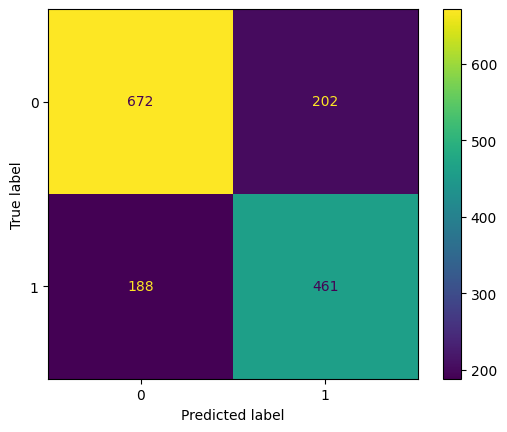

In [77]:
print(classification_report(y_val, labels))
cm = confusion_matrix(y_val, labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

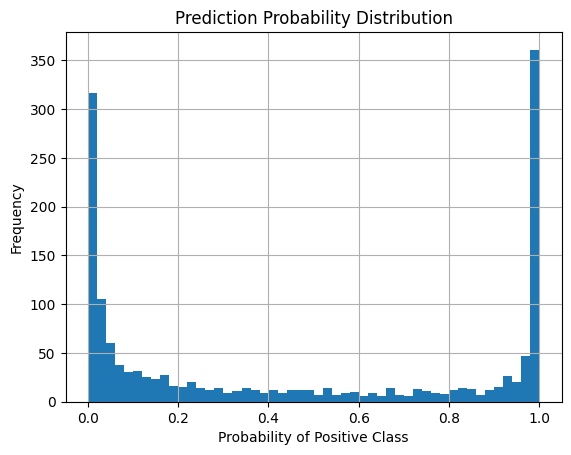

In [78]:
plt.hist(preds, bins=50)
plt.title("Prediction Probability Distribution")
plt.xlabel("Probability of Positive Class")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [79]:
test_df['clean_text'] = test_df['text'].apply(clean_text)
test_seq = tokenizer.texts_to_sequences(test_df['clean_text'])
test_pad = pad_sequences(test_seq, maxlen=MAX_LEN)
test_pred_prob = model.predict(test_pad)
test_pred = (test_pred_prob > 0.5).astype(int).flatten()

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [80]:
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': test_pred
})

submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [81]:
# submission.to_csv("submission.csv", index=False)
#
# !kaggle competitions submit -c histopathologic-cancer-detection -f submission.csv -m "Submission"

## Conclusion

The model preformed moderately well. I got a 0.76555 on Kaggle. 

The training AUC ~98%, but my false positive and false negatives were pretty high. Validation AUC plateaus and then declines slightly after epoch 1 might mean there is some overfitting. 

I think there are some things I can do differently to bump up the score. Maybe look into different tokenizing. Lemmatization might improve things. I could look into Bidirectional LSTM or a transformer like BERT.